# Kuramoto Model

We propose to study by numerical simulation the **paradigmatic model of synchronization**, the Kuramoto model. Introduced by Kuramoto in 1975, it illustrates the propensity of coupled oscillators to evolve towards a collective oscillation when the coupling exceeds a critical value. After 35 years, many situations have been considered. In this homework, we restrict ourselves to some fundamental properties.

You can use any programming language for your code. The simulations are not very demanding; if you use Python with NumPy and avoid unnecessary loops, a typical execution time should be close to 2 minutes on a laptop, and less than 10 minutes in the final part of the homework.

We consider \(N\) one-dimensional rotors arranged on a ring. The equations of motion are:

$$
\dot{\theta}_i \;=\; \omega_i 
\;+\; \sum_{j=1}^N \frac{K}{N}\,\sin\bigl(\theta_j - \theta_i\bigr),
$$

where \(\theta_i\) and \(\omega_i\) are the phase and natural frequency of the \(i\)-th rotor. The parameter \(K\) is the coupling strength and the factor \(\tfrac{1}{N}\) ensures the model is well-defined in the thermodynamic limit. The frequencies \(\{\omega_i\}\) are drawn from a centered distribution.

To visualize the collective dynamics, we introduce the **complex order parameter**:

$$
r(t)\,e^{i\,\Psi(t)} 
\;=\; \frac{1}{N} \sum_{i=1}^N e^{i\,\theta_i(t)}.
$$

---

1. **Rewrite the equations of motion**  

   Show that the equations of motion can be rewritten as  

   $$
   \dot{\theta}_i 
   \;=\; \omega_i 
   \;+\; K\,r\,\sin\bigl(\Psi - \theta_i\bigr)
   $$

---

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --------------------------
# 1) Define parameters
# --------------------------
N = 10
tmax = 100.0
t_eval = np.linspace(0, tmax, 1000)   # times at which we want the solution

# Frequencies drawn from a centered Gaussian, e.g. mean=0, std=1
np.random.seed(123)  # for reproducible results
omega = np.random.normal(loc=0.0, scale=1.0, size=N)

# Initial phases from uniform([-pi, pi])
theta0 = np.random.uniform(-np.pi, np.pi, N)

def kuramoto_equations(t, theta, omega, K):
    """
    dtheta_i/dt = omega_i + (K/N) * sum_j sin(theta_j - theta_i)
    """
    N = len(theta)
    # we can compute sines in a vectorized way:
    # theta.shape -> (N,)
    # Expand dimensions to compute theta_j - theta_i
    # shape broadcasting: differences[i,j] = theta[j] - theta[i]
    diff = np.subtract.outer(theta, theta)  # shape (N,N)
     # sin_matrix[i,j] = sin(theta[i] - theta[j]), but we want sin(theta_j - theta_i),
    # so we either swap them or just take negative sign:
    # sin(theta_j - theta_i) = -sin(theta_i - theta_j)
    coupling = (K/N) * np.sum(np.sin(diff), axis=1)
    return omega + coupling

# Function to run a single simulation for given K
def run_kuramoto(K):
    sol = solve_ivp(fun=lambda t, th: kuramoto_equations(t, th, omega, K),
                    t_span=(0, tmax),
                    y0=theta0,
                    t_eval=t_eval,
                    method='RK45',  # adaptive RK
                    rtol=1e-8, atol=1e-8)
    return sol

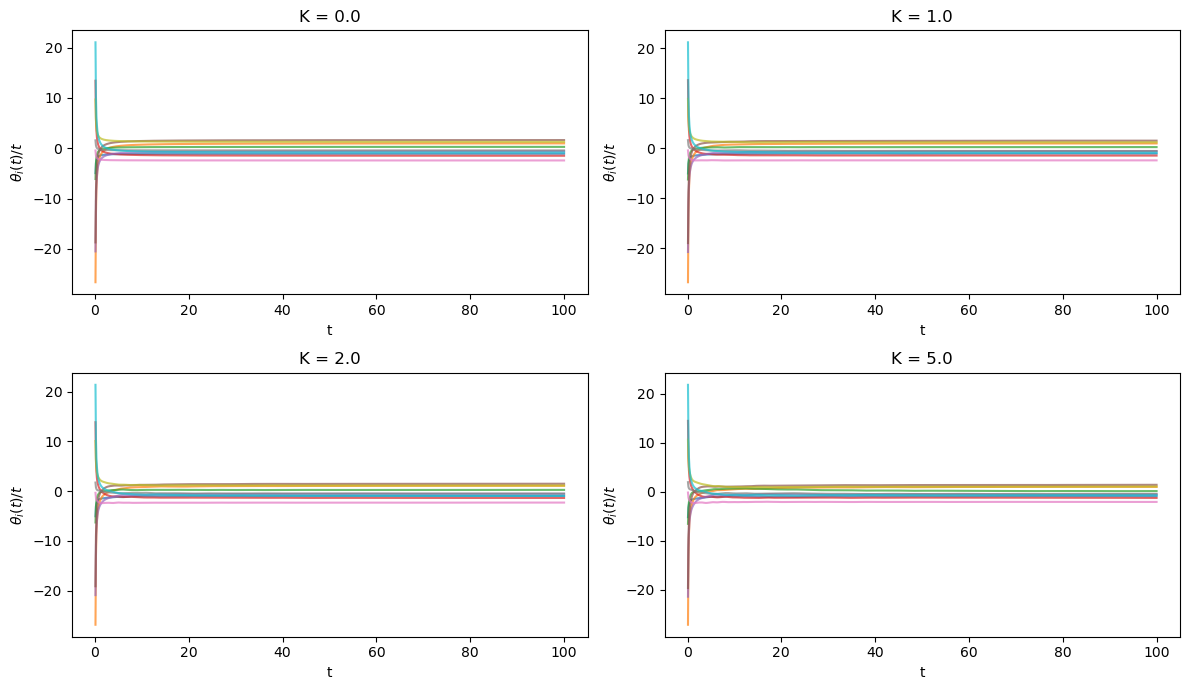

In [56]:
# --------------------------
# 2) Run for different K
# --------------------------

K_values = [0.0, 1.0, 2.0, 5.0]

fig, axs = plt.subplots(2, 2, figsize=(12,7))
axs = axs.ravel()

for i, K in enumerate(K_values):
    sol = run_kuramoto(K)
    t = sol.t
    theta_t = sol.y  # shape (N, len(t))
    
    # Compute theta_i(t)/t for i=1..N
    # avoid dividing by zero at t=0 => shift the index or handle t=0 carefully
    # here we skip the first time point t[0] = 0
    t_nonzero = t[1:]
    theta_div_t = theta_t[:, 1:] / t_nonzero
    
    # Plot results for each oscillator
    for n in range(N):
        axs[i].plot(t_nonzero, theta_div_t[n, :], label=f"Osc {n+1}", alpha=0.7)
    
    axs[i].set_title(f"K = {K}")
    axs[i].set_xlabel("t")
    axs[i].set_ylabel(r"$\theta_i(t)/t$")

plt.tight_layout()
plt.show()

In [ ]:
def simulate_for_K(K, N, Nrep=10):
    """
    Fait Nrep réalisations indépendantes, retourne la moyenne de r(t_final)
    (ou plusieurs instants) selon les besoins.
    """
    r_final_vals = []
    for _ in range(Nrep):
        # 1) Génération des fréquences
        omega = np.random.normal(0.0, 1.0, N)
        omega -= np.mean(omega)  # centrage
        
        # 2) Phases initiales aléatoires
        theta0 = np.random.uniform(-np.pi, np.pi, N)
        
        # 3) Intégration
        sol = solve_ivp(
            lambda t,th: kuramoto_equations(t, th, omega, K),
            t_span=(0, 50),  # ou plus grand si besoin
            y0=theta0,
            t_eval=[50],     # on ne sauvegarde que la fin
            method='RK45'
        )
        
        theta_final = sol.y[:, -1]
        # 4) Calcul de r(t_final)
        real_part = np.mean(np.cos(theta_final))
        imag_part = np.mean(np.sin(theta_final))
        r_final = np.sqrt(real_part**2 + imag_part**2)
        r_final_vals.append(r_final)
    
    return np.mean(r_final_vals)  # moyenne sur Nrep

# -----------
N_list = [100, 500, 2000, 5000, 15000]
K_values = np.linspace(1.0, 2.0, 25)

plt.figure(figsize=(6,5))

for N in N_list:
    r_means = []
    for K in K_values:
        r_means.append(simulate_for_K(K, N, Nrep=30))
    plt.plot(K_values, r_means, label=f'N={N}')

plt.xlabel('K')
plt.ylabel('r')
plt.legend()
plt.tight_layout()
plt.show()